# TP 4 : Fillrates

BROSSETTE Camille  
LEGRAND Maxime

## 0. Set-up

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from datetime import datetime

In [3]:
num = [720, 1102, 1662, 1664, 2255, 2574, 2586, 5685, 8695864]
dft = {}
for i in range(1, 10):
    dft[i] = pd.read_pickle("../data4/strades_info_"+str(num[i-1])+".h5")

In [4]:
for i in range(1,10):
    dti = dft[i]['ts_market'].iloc[0]
    dft[i] = dft[i][(dft[i]['bid'] < dft[i]['ask'])
                    &(dft[i]['bid'] != 0)
                    &(dft[i]['bid'] != 999999)
                    &(dft[i]['ask'] != 0)
                    &(dft[i]['ask'] != 999999)
                    &(dft[i]['source'] == 'LSE')
                    &(dft[i]['volume'] != 0)
                    &(dft[i]['qty'] != 0)
                    &(dft[i]['side'] != 'U')]
    if i==2:
        dft[i] = dft[i][(dft[i]['ts_market'] > datetime(dti.year, dti.month, dti.day, 7, 0))
                         &(dft[i]['ts_market'] < datetime(dti.year, dti.month, dti.day, 15, 30))]
    else:
        dft[i] = dft[i][(dft[i]['ts_market'] > datetime(dti.year, dti.month, dti.day, 8, 0))
                         &(dft[i]['ts_market'] < datetime(dti.year, dti.month, dti.day, 16, 30))]

In [5]:
tick = [0.05, 0.05, 0.1, 0.01, 0.05, 0.1, 0.1, 0.1, 0.05]

In [6]:
for i in range(1,10):
    dft[i]['bid1']=dft[i]['bid']-tick[i-1]
    dft[i]['bid2']=dft[i]['bid']-2*tick[i-1]
    dft[i]['ask1']=dft[i]['ask']+tick[i-1]
    dft[i]['ask2']=dft[i]['ask']+2*tick[i-1]

In [7]:
trades = {}
for i in range(1,10):
    trades[i] = dft[i].set_index('ts_market')

## I. Passive Orders and Probability of Execution

### 1. Functions

In [8]:
def Bid_proba_ex(Trades, time_step):
    
    Bid_dist = ['bid', 'bid1', 'bid2']
    
    Bid = np.array([Trades[Bid_dist[0]].resample(time_step).first(),
                    Trades[Bid_dist[1]].resample(time_step).first(),
                    Trades[Bid_dist[2]].resample(time_step).first()])
                    
    Trade = Trades['price'].resample(time_step).min()
    
    res = np.array([[(Trade[i]<Bid[0][i]) for i in range(len(Bid[0]))],
                   [(Trade[i]<Bid[1][i]) for i in range(len(Bid[1]))],
                   [(Trade[i]<Bid[2][i]) for i in range(len(Bid[2]))]])
    
    resf = np.array([res[0].mean(),
                     res[1].mean(),
                     res[2].mean()])
    
    return resf    

In [9]:
def Ask_proba_ex(Trades, time_step):
    Ask_dist = ['ask', 'ask1', 'ask2']
    
    Ask = np.array([Trades[Ask_dist[0]].resample(time_step).first(),
                    Trades[Ask_dist[1]].resample(time_step).first(),
                    Trades[Ask_dist[2]].resample(time_step).first()])
                    
    Trade = Trades['price'].resample(time_step).max()
    
    res = np.array([[(Trade[i]>Ask[0][i]) for i in range(len(Ask[0]))],
                   [(Trade[i]>Ask[1][i]) for i in range(len(Ask[1]))],
                   [(Trade[i]>Ask[2][i]) for i in range(len(Ask[2]))]])
    resf = np.array([res[0].mean(),
                     res[1].mean(),
                     res[2].mean()])
    
    return resf

### 2. Curves

In [10]:
J = 5 # Dataset used from now
t0 = 30 # Minimum time
T = 150 # Maximum time
dt = 30 # Time step in range

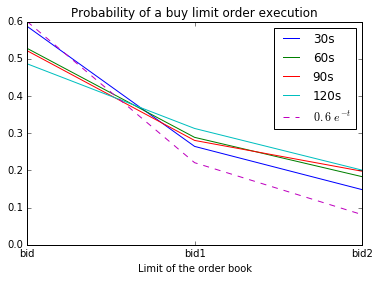

In [11]:
f, ax = plt.subplots()

for s in range(t0,T,dt):
    P_Bid = Bid_proba_ex(trades[J], (str(s) + 's'))
    ax.plot([0,1,2], P_Bid/P_Bid.sum(), label = (str(s) + 's'))
    
ax.plot([0,1,2], [0.6*np.exp(0), 0.6*np.exp(-1), 0.6*np.exp(-2)], '--', label = '$0.6\ e^{-t}$')
    
ax.set_title('Probability of a buy limit order execution')
ax.set_xlabel('Limit of the order book')
ax.set_xticks([0,1,2])
ax.set_xticklabels(('bid', 'bid1', 'bid2'))
ax.legend()

plt.show()

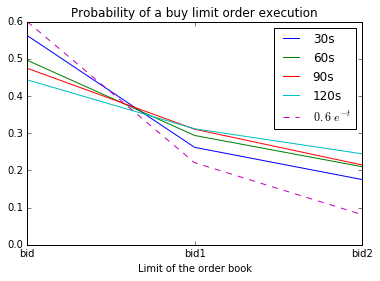

In [12]:
f, ax = plt.subplots()

for s in range(t0,T,dt):
    P_Ask = Ask_proba_ex(trades[J], (str(s) + 's'))
    ax.plot([0,1,2], P_Ask/P_Ask.sum(), label = (str(s) + 's'))
    
ax.plot([0,1,2], [0.6*np.exp(0), 0.6*np.exp(-1), 0.6*np.exp(-2)], '--', label = '$0.6\ e^{-t}$')
    
ax.set_title('Probability of a buy limit order execution')
ax.set_xlabel('Limit of the order book')
ax.set_xticks([0,1,2])
ax.set_xticklabels(('bid', 'bid1', 'bid2'))
ax.legend()

plt.show()

On remarque que lorsque le pas de temps tend vers $0$, les probabilités semblent converger vers une fonction exponentielle. Les graphes ci-dessus les mettent en correspondance avec $t \mapsto 0.6\ e^{-t}$. On observe une symétrie des paramètres de l'exponentielle entre le `bid` et l'`ask`.

## II. Fillrate

### 1. Function

In [13]:
def Fillrate(Trades, dist, time_step, time_waiting):
    Bid_dist = ['bid', 'bid1', 'bid2']
    Bid = Trades[Bid_dist[dist]].resample(time_step).first()
    Trade = Trades['price'].resample(time_step).min()
    
    Res = Trade
    for i in range(len(Bid)):
        Res[i] = (Trade[i]<Bid[i])
    
    res = Res.resample(time_waiting).sum()    
    
    return res

Comme dans l'énoncé, on fait les test avec une quantité $q=1$, plus simple à implanter et bien assez représentatif de la donnée que l'on cherche à représenter.

### 2. Curves

In [15]:
Waiting_time = ['5Min', '10Min', '20Min']
dt_string = '1s'

fillrate = {}
time = {}
price = {}

for t in range(len(Waiting_time)):
    for d in range(0,3):
        fillrate[(t,d)] = Fillrate(trades[J], d, dt_string, Waiting_time[t])
        time[(t,d)] =  np.linspace(8,16.5,len(fillrate[(t,d)]))
        price[(t,d)] = trades[J]['price']

In [36]:
def printFillRate(d=d):
    color = ['lightgreen', 'orange', 'cyan']
    n = len(Waiting_time)
    for t in range(n):
        plt.figure(figsize=(16,4))
        plt.subplot(2,1,1)
        plt.title('Fillrate for $d='+str(d)+'$ and $\Delta T=$'+str(Waiting_time[t]))
        plt.plot(np.linspace(8,16.5, len(price[(t,d)])), price[(t,d)], color='blue')
        plt.subplot(2,1,2)
        plt.bar(time[(t,d)], fillrate[(t,d)], label=Waiting_time[t], color=color[t], width=0.05)
        plt.legend()
        plt.show()

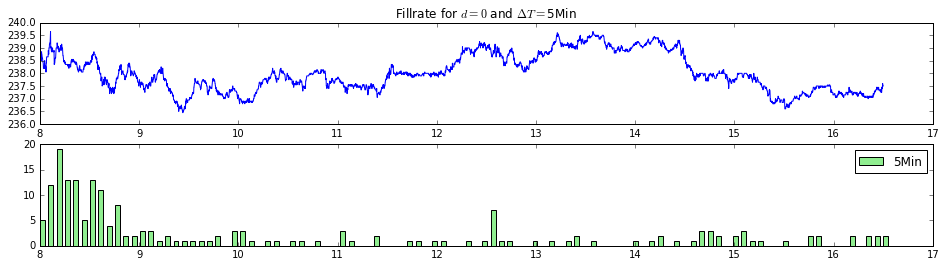

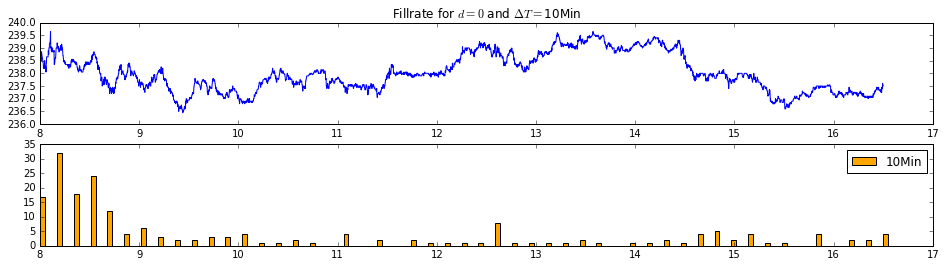

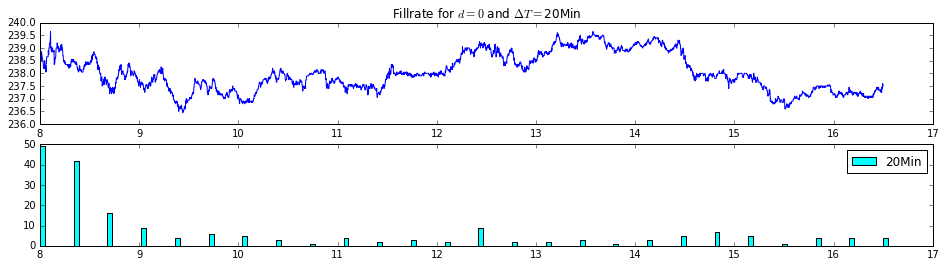

In [38]:
printFillRate(d=0) # Set d as wanted amongst {0,1,2}

## III. Inventory and Market Making

### 1. Inventory

### 2. Static Market Making

### 3. Dynamical Market Making

## IV. Profit & Loss

## Conclusion